#**Lending Club Case Study**
##**Problem Statement:**
A consumer finance company is aiming to find types of risks associated with a given loan application. 
If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company. If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.
The company is aiming towards identifying these risky loan applicants so that the risk on lending such loans are reduced thereby cutting down the amount of credit loss



---


##**Aim of the Analysis:**
To identify the risky loan applicants and to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default which can be utilised for its portfolio and risk assessment.


In [ ]:
#Importing the required libraries for the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data Sourcing

In [ ]:
#obtaining the data
import os
from zipfile import ZipFile
import requests


DATA_URL = "https://cdn.upgrad.com/UpGrad/temp/3ba74fb7-bd88-4854-8597-1c225a5aed99/loan.zip"

ZIP_FILE_NAME = "loan.zip"

FILE_NAME = "loan.csv"

r = requests.get(DATA_URL)
if not os.path.exists(ZIP_FILE_NAME):
  with open(ZIP_FILE_NAME, 'wb') as file:
    file.write(r.content)
with ZipFile(ZIP_FILE_NAME, 'r') as z:
  z.extractall()

#importing the data using pandas
loan = pd.read_csv(FILE_NAME)
loan.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.0,0.0,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.0,0.0,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.0,0.0,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
print("Shape of the dataframe imported",loan.shape)

Shape of the dataframe imported (39717, 111)


##Data Cleaning

In [ ]:
#checking the null values present in the source data
loan.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [ ]:
def drop_columns(df, columns):
  """ Removes columns from dataframe
  Parameters:
    df: Pandas dataframe
    columns: List of columns to drop
  """
  col_to_drop = list(set(df.columns).intersection(columns))
  print("Dropping columns", col_to_drop)
  return df.drop(labels=col_to_drop, axis=1)

In [ ]:
def get_na_cols(df, axis = 1, threshold= 0.2):
  """Return pandas series of null value statistics
  Parameters:
    df: Pandas datadrame
    axis : {0 or rows, 1 or columns}, default 1
    threshold : Percentage of null value in rows/columns
  """
  if axis == 1:
    na_mean = loan.isna().mean()
  else:
    na_mean = loan.T.isna().mean()
  return na_mean[na_mean.values > threshold]


In [ ]:
def removeNa(df, axis = 1, threshold= 0.2):
  """ Removes na value from data frame
  Parameters:
    df : Pandas Dataframe
    axis : {0 or rows, 1 or columns}, default 1
    threshold : Percentage of null value in rows/columns
  """
  na_cols = get_na_cols(df, axis, threshold)
  old_shape = df.shape

  df = df.drop(labels= na_cols.index, axis= axis)
  new_shape = df.shape
  print("Removes: ", old_shape[0] - new_shape[0], "rows, ", old_shape[1] - new_shape[1], "columns.")
  return df

In [ ]:
# Remove columns having more than 32% null value
loan = removeNa(loan, 1, 0.32)

# Drop columns having same value in it.
unique = loan.nunique()
unique = unique[unique.values == 1]
print("Dropping", len(unique.index), "columns having same value")
loan = drop_columns(loan, unique.index)

# Drop row having moe than 32% of null value
loan = removeNa(loan, 0, 0.32)

Removes:  0 rows,  58 columns.
Dropping 9 columns having same value
Dropping columns ['pymnt_plan', 'initial_list_status', 'application_type', 'collections_12_mths_ex_med', 'delinq_amnt', 'chargeoff_within_12_mths', 'acc_now_delinq', 'tax_liens', 'policy_code']
Removes:  0 rows,  0 columns.


In [ ]:
#Removeing columns that may contain vague information or not required for current analysis
#last_pymnt_d is null for Charged off applicants, hence dropping the attribute
irrelevent_cols = ["id", "member_id", "url","title","last_pymnt_d","zip_code","out_prncp","out_prncp_inv","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee"]
loan = drop_columns(loan, irrelevent_cols)
print("Shape of the loan df:",loan.shape)

Dropping columns ['member_id', 'title', 'id', 'last_pymnt_d', 'out_prncp_inv', 'collection_recovery_fee', 'total_rec_int', 'out_prncp', 'zip_code', 'recoveries', 'total_rec_late_fee', 'url']
Shape of the loan df: (39717, 32)


In [ ]:
#Proceeding on Data Cleaning to Standardize values, Fix missing values, Fix invalid values
na_cols = get_na_cols(loan, 1, 0)

loan[na_cols.index].describe()
loan[na_cols.index][loan.emp_length.isna() & loan.emp_title.isna()]
# Dropping the 1019 row missing in emp_title and emp_length
loan.dropna(subset=['emp_title', 'emp_length'], inplace=True)

date_cols = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']
loan[date_cols] = loan[date_cols].apply(lambda x: pd.to_datetime(x, format="%b-%y"))

na_cols = get_na_cols(loan, 1, 0)
round(loan.describe(), 2)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,pub_rec_bankruptcies
count,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,37202.00,36548.00
mean,11274.67,11002.90,10442.17,325.91,69239.48,13.39,0.15,0.87,9.34,0.05,13446.00,22.17,12247.33,11648.92,9867.12,2714.77,0.04
std,7419.65,7155.26,7098.23,207.48,64191.76,6.65,0.49,1.07,4.39,0.23,15744.03,11.39,9022.65,8925.86,7040.92,4452.25,0.20
min,500.00,500.00,0.00,16.08,4000.00,0.00,0.00,0.00,2.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00
25%,5550.00,5500.00,5000.00,168.62,41551.10,8.30,0.00,0.00,6.00,0.00,3794.00,14.00,5643.25,5210.61,4800.00,223.48,0.00
50%,10000.00,10000.00,9000.00,283.18,60000.00,13.50,0.00,1.00,9.00,0.00,8997.50,21.00,10057.63,9405.20,8000.00,561.72,0.00
75%,15000.00,15000.00,14400.00,431.76,82800.00,18.65,0.00,1.00,12.00,0.00,17187.00,29.00,16637.86,15907.39,13850.00,3396.16,0.00
max,35000.00,35000.00,35000.00,1305.19,6000000.00,29.99,11.00,8.00,44.00,4.00,149588.00,90.00,58563.68,58563.68,35000.02,36115.20,2.00


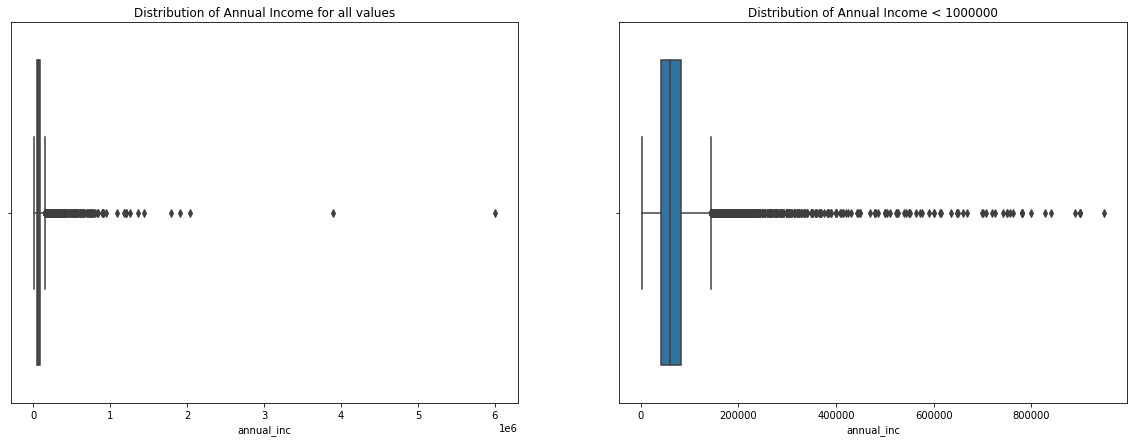

In [ ]:
#Analyzing the distribution of Loan Amount
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
ax = sns.boxplot(loan.annual_inc)
plt.title("Distribution of Annual Income for all values")
loan = loan[loan.annual_inc<1000000]
# in box blot we can clearly see that we have very few applicants whose income is more than 1000000. We can can consider these record as outlier, so removed from our analysis.
ax1 = fig.add_subplot(122)
ax1 = sns.boxplot('annual_inc', data=loan)
plt.title("Distribution of Annual Income < 1000000")
plt.show()

In [ ]:
#checking if any rows are duplicated
print("Number of rows duplicated in the source df:",len(loan[loan.duplicated()]))

Number of rows duplicated in the source df: 0


In [ ]:
#creating a copy of the original dataframe
loan_df = loan.copy()

##Adding required Derived Metrics for further analysis

In [ ]:
def get_bin_series(column, bin_size, increment=None, labels=None):
  """Return series data for range column
  Parameters:
    column: Pandas series of numeric data
    bin_size: number of of bin
    increment: Size of bin interval
  """
  bins = [x * increment for x in range(bin_size)]
  if not bool(labels):
    labels = ["{}-{}".format(x, x+increment) for x in bins[:-1]]
  return pd.cut(column, bins=bins, labels=labels)

#binning the annual income attribute
loan['annual_income_range'] = get_bin_series(loan.annual_inc, 6, 200000)

#binning the loan amount attribute
loan['loan_amount_range'] = get_bin_series(loan.loan_amnt, 6, 7000)

loan[['annual_income_range','loan_amount_range']][:3]

,annual_income_range,loan_amount_range
1,0-200000,0-7000
3,0-200000,7000-14000
4,0-200000,0-7000


In [ ]:
#transforming and binning the interest rate attribute
loan['int_rate'] = loan.int_rate.astype(str).apply(lambda rate: float(rate.replace("%", "").strip()))
loan['int_rate_range'] = get_bin_series(loan.int_rate, 6, 5)
loan[['int_rate','int_rate_range']][:3]

,int_rate,int_rate_range
1,15.27,15-20
3,13.49,10-15
4,12.69,10-15


In [ ]:
#transforming and binning the emp_length attribute
loan['emp_years'] = loan['emp_length'].str.replace('< 1',"0").str.strip()
loan['emp_years'] = loan['emp_years'].str.extract('(\d+)')
loan[['emp_years']] = loan[['emp_years']].apply(pd.to_numeric)

labels = ['<1year','1-3years','4-6years','7-9years','10+years']
bins=[-1.0,0.0,3.0,6.0,9.0,10.0]
loan['bin_emp_years'] = pd.cut(loan['emp_years'],bins,labels=labels)
loan[['emp_years','bin_emp_years']][:3]

,emp_years,bin_emp_years
1,0,<1year
3,10,10+years
4,1,1-3years


In [ ]:
#extracting the year and month info from the attribute, issue_d
loan['month'] = loan['issue_d'].dt.strftime('%b')
loan['year'] = loan.issue_d.dt.year
loan[['issue_d','loan_amnt','loan_status','month','year']][:3]

,issue_d,loan_amnt,loan_status,month,year
1,2011-12-01,2500,Charged Off,Dec,2011
3,2011-12-01,10000,Fully Paid,Dec,2011
4,2011-12-01,3000,Current,Dec,2011


##Univariate Analysis

Distinct count present in the attribute loan_status:


,index,loan_status
0,Fully Paid,30992
1,Charged Off,5130
2,Current,1066


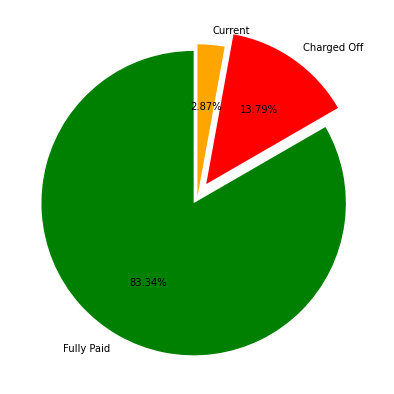

In [ ]:
#Calculating the distinct number of values prsent in the attribute, loan_status
print("Distinct count present in the attribute loan_status:")
loan_status = loan.loan_status.value_counts()
display(loan_status.reset_index())

#plotting the values
#plotting the values
plt.figure(figsize=(10,7))
plt.pie(loan.loan_status.value_counts(),autopct='%.2f%%',explode=(0.05,0.1,0),startangle=90,colors=['green','red','orange'],
        labels=['Fully Paid', 'Charged Off','Current'])
plt.show()

The given data constitutes of, 
*   Applicants who have Fully Paid their loans: 83% 
*   Applicants who have Defaulted their loans: 14% 
*   Applicants who have Currently paying their loans: 3%  

Since the applicants who are currently paying the loans can go either way, they are not being considered as part of this analysis






In [ ]:
#elimnating the current loan status
loan.loan_status.unique()
loan_analysis = loan[loan.loan_status != 'Current']
print("Shape of the new df:",loan_analysis.shape)

Shape of the new df: (36122, 39)


In [ ]:
#Loss of data calculation:
print("Loss of data(in percentage) when compared with the original 39717 observations:{:.2%}".format(1-(36122/39717)))

Loss of data(in percentage) when compared with the original 39717 observations:9.05%


In [ ]:
#Information on the attributes present in the loan dataframe
loan_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36122 entries, 1 to 39716
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_amnt             36122 non-null  int64         
 1   funded_amnt           36122 non-null  int64         
 2   funded_amnt_inv       36122 non-null  float64       
 3   term                  36122 non-null  object        
 4   int_rate              36122 non-null  float64       
 5   installment           36122 non-null  float64       
 6   grade                 36122 non-null  object        
 7   sub_grade             36122 non-null  object        
 8   emp_title             36122 non-null  object        
 9   emp_length            36122 non-null  object        
 10  home_ownership        36122 non-null  object        
 11  annual_inc            36122 non-null  float64       
 12  verification_status   36122 non-null  object        
 13  issue_d         

In [ ]:
#Number of Unique values present in the loan dataframe
loan_analysis.nunique().sort_values()

term                        2
loan_status                 2
verification_status         3
pub_rec_bankruptcies        3
int_rate_range              4
pub_rec                     5
annual_income_range         5
home_ownership              5
year                        5
bin_emp_years               5
loan_amount_range           5
grade                       7
inq_last_6mths              9
emp_length                 11
emp_years                  11
delinq_2yrs                11
month                      12
purpose                    14
sub_grade                  35
open_acc                   40
addr_state                 50
issue_d                    55
total_acc                  80
last_credit_pull_d        106
int_rate                  368
earliest_cr_line          509
loan_amnt                 858
funded_amnt              1008
revol_util               1081
dti                      2842
annual_inc               4892
total_rec_prncp          6330
funded_amnt_inv          7662
installmen

In [ ]:
loan_analysis.isnull().sum()

loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_title                 0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               46
total_acc                 0
total_pymnt               0
total_pymnt_inv           0
total_rec_prncp           0
last_pymnt_amnt           0
last_credit_pull_d        0
pub_rec_bankruptcies    653
annual_income_range       0
loan_amount_range         0
int_rate_range            0
emp_years           

In [ ]:
#dropping the columns that have missing values and are not contributing to the current analysis
loan_analysis = drop_columns(loan_analysis, ['revol_util','pub_rec_bankruptcies'])

Dropping columns ['pub_rec_bankruptcies', 'revol_util']


Distribution of loan amount

In [ ]:
#creating dataframes for analyzing the factors that lead to default
loan_default = loan_analysis[loan_analysis.loan_status=='Charged Off']
loan_paid = loan_analysis[loan_analysis.loan_status=='Fully Paid']

In [ ]:
#describing the distribution of the attribute annual_inc with various percentiles
l1 = round(loan_default.loan_amnt.describe(percentiles=[0.05,0.1,0.2,0.25,0.70,0.75,0.80,0.90,0.95,0.99]),2)
l2 = round(loan_paid.loan_amnt.describe(percentiles=[0.05,0.1,0.2,0.25,0.70,0.75,0.80,0.90,0.95,0.99]),2)
pd.concat([l1,l2],axis=1)

,loan_amnt,loan_amnt
count,5130.00,30992.00
mean,12236.15,10915.45
std,8056.53,7165.51
min,900.00,500.00
5%,2400.00,2400.00
10%,3250.00,3200.00
20%,5000.00,5000.00
25%,6000.00,5400.00
50%,10000.00,9600.00
70%,15000.00,13200.00


In [ ]:
def dist(col):
  '''
  The function takes 1 input value
  col: Name of the column whose distribution is to be plotted 
  '''
  fig = plt.figure(figsize=(20,7))
  ax = fig.add_subplot(121)
  ax = sns.distplot(loan_default[col],bins=30)
  plt.title("Distribution of {} for loan_status='Charged Off'".format(col))

  ax1 = fig.add_subplot(122)
  ax1 = sns.distplot(loan_paid[col],bins=30)
  plt.title("Distribution of {} for loan_status='Fully Paid'".format(col))
  plt.show()

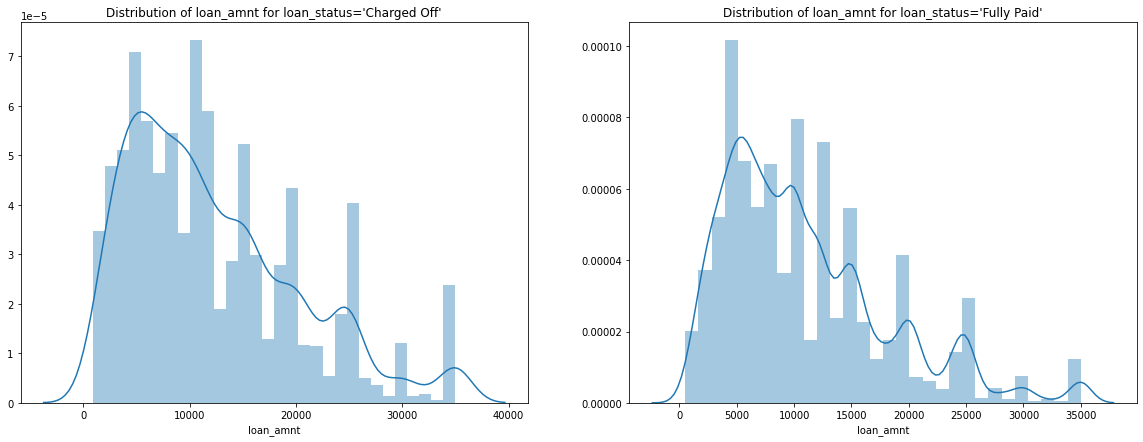

In [ ]:
#Analyzing the distribution of Loan Amount
dist('loan_amnt')

In [ ]:
#describing the distribution of the attribute annual_inc with various percentiles
a1 = round(loan_default.annual_inc.describe(percentiles=[0.05,0.1,0.2,0.25,0.70,0.75,0.80,0.90,0.95,0.99]),2)
a2 = round(loan_paid.annual_inc.describe(percentiles=[0.05,0.1,0.2,0.25,0.70,0.75,0.80,0.90,0.95,0.99]),2)
pd.concat([a1,a2],axis=1)

,annual_inc,annual_inc
count,5130.00,30992.00
mean,62677.71,69253.39
std,44684.65,46882.26
min,4080.00,4000.00
5%,22800.00,24998.20
10%,27996.00,30000.00
20%,35004.00,38500.00
25%,38214.75,42000.00
50%,54000.00,60000.00
70%,70000.00,77526.07


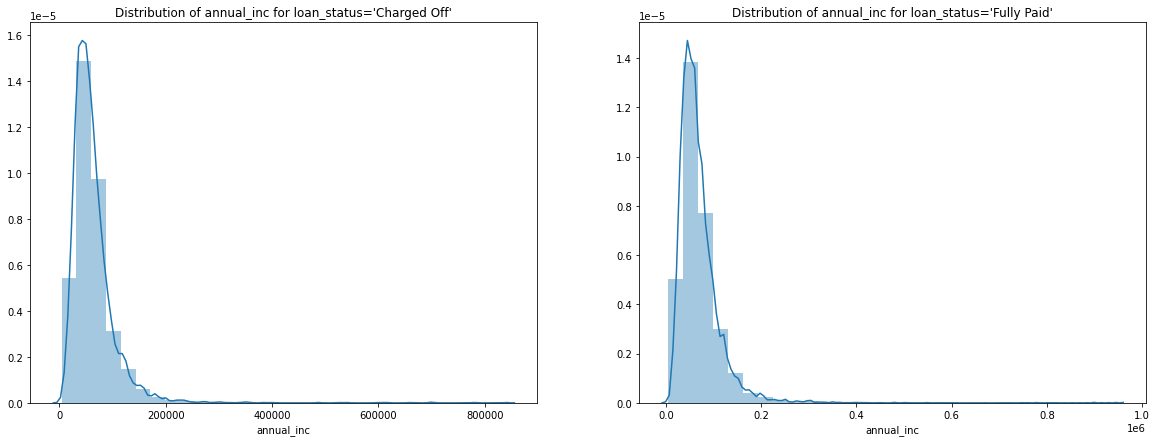

In [ ]:
#Analyzing the distribution of Annual Income
dist('annual_inc')

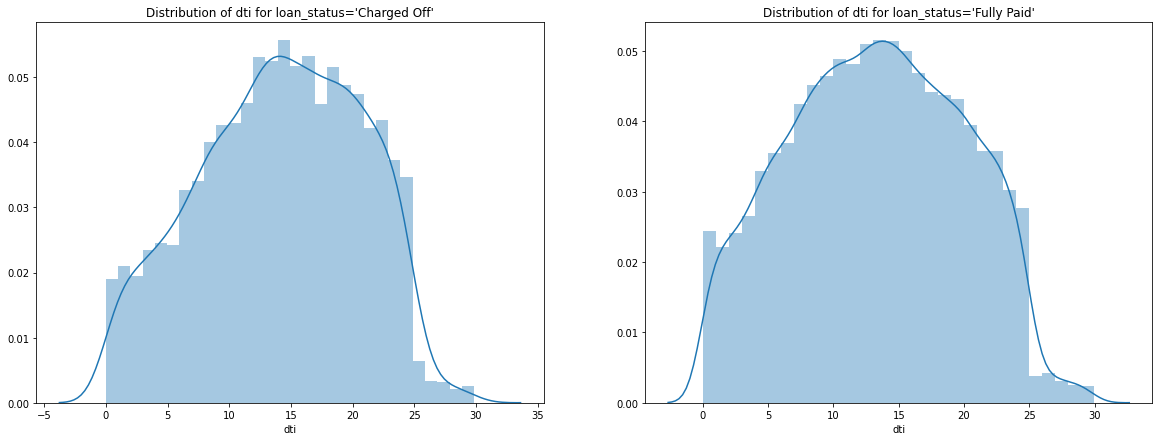

In [ ]:
#Analyzing the distribution of DTI
dist('dti')

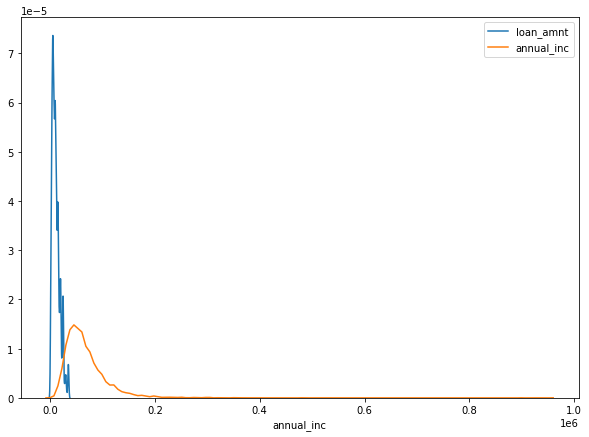

In [ ]:
#visualizing the distribution of loan amount and annual income
fig = plt.figure(figsize=(10,7))
sns.distplot(loan_analysis.loan_amnt,hist=False, label='loan_amnt')
sns.distplot(loan_analysis.annual_inc, hist=False, label='annual_inc')
plt.show()

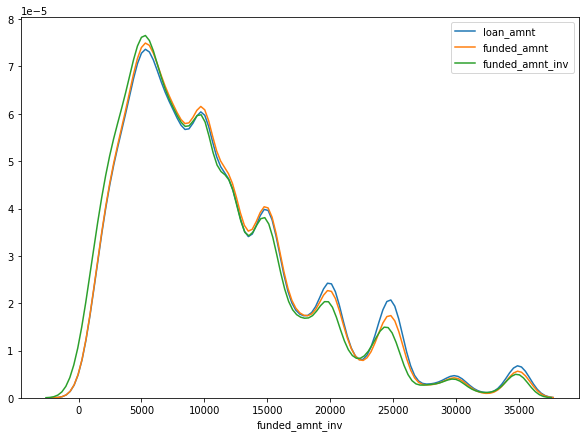

In [ ]:
#visualizing distribution of loan amount vs funded amount vs amount funded by investors
fig = plt.figure(figsize=(10,7))
sns.distplot(loan_analysis.loan_amnt,hist=False, label='loan_amnt')
sns.distplot(loan_analysis.funded_amnt, hist=False, label='funded_amnt')
sns.distplot(loan_analysis.funded_amnt_inv,hist=False, label='funded_amnt_inv')
plt.show()

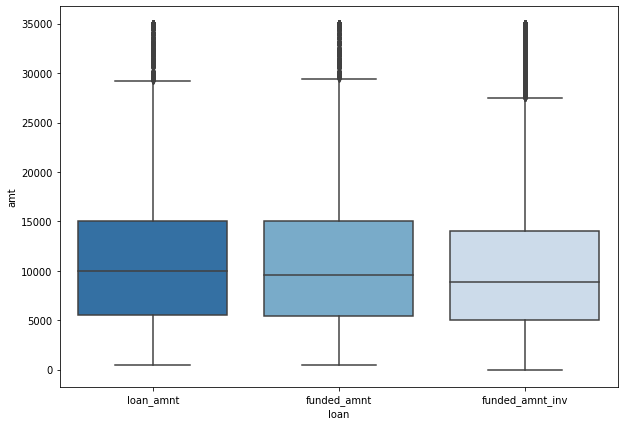

In [ ]:
#Analyzing the distribution of the Loan amount and the funded amount present in the dataset
df1 = pd.melt(loan_analysis,value_vars=['loan_amnt','funded_amnt','funded_amnt_inv'],var_name='loan',value_name='amt')
#df1.head()

plt.figure(figsize=(10,7))
sns.boxplot(df1.loan,df1.amt,palette='Blues_r')
plt.show()

As seen from the graph, 
1. funded_amnt(The total amount committed to that loan at a point in time) is mostly equivalent with 2% variation to the loan_amnt(The listed amount of the loan applied for by the borrower)
2. funded_amnt_inv(The total amount committed by investors for that loan at a point in time) is 7% less than the loan_amnt applied by the borrower.

In [ ]:
#Calculation for the percentage variations between the Loan amount and the funded amount present in the dataset
print("Difference between loan_amnt and funded_amnt in loan df:{:.2%}".format((loan_analysis.loan_amnt.sum()-loan_analysis.funded_amnt.sum())/loan_analysis.loan_amnt.sum()))
print("Difference between loan_amnt and funded_amnt_inv in loan df:{:.2%}".format((loan_analysis.loan_amnt.sum()-loan_analysis.funded_amnt_inv.sum())/loan_analysis.loan_amnt.sum()))

Difference between loan_amnt and funded_amnt in loan df:2.37%
Difference between loan_amnt and funded_amnt_inv in loan df:7.53%


Analyzing the distribution of various factors against the attribute loan_status

In [ ]:
def analyse_col(df,col):
  """
  The function takes 2 input values,
  df: name of the dataframe 
  col: name of the column to be analysed against loan_status
  The function outputs a dataframe with percentage values corresponding to the column's presence against the given loan status
  """
  df2 = df.groupby([col,'loan_status'])[col].count().to_frame('c1').reset_index()
  df2['dist_perct'] = round(100*(df2.c1/len(df.index)),2).astype(str) + '%'
  df2 = df2.sort_values(by=['loan_status','c1'],ascending=False)
  df2 = df2.set_index(['loan_status',col])
  print('Various values present in the attribue {}:'.format(col))
  return(pd.pivot_table(df2, values='dist_perct', index=['loan_status'], columns=[col],aggfunc=np.sum))


In [ ]:
def uni_variate_plot(df,col,x=10,y=5):
  """
  The function takes 6 input values,
  df: name of the dataframe 
  col: name of the column to be analysed against loan_status
  x,y: customization of plot size
  The function plots the distict number of values available in the input column divided between the available loan_status
  """
  ax = plt.figure(figsize=(x,y))
  ord1 = list(set(loan_paid[col].values))
  #ord2 = list(set(loan_default[col].values))
  ax = sns.countplot(y=loan_paid[col],order=ord1,color='teal')
  sns.countplot(y=loan_default[col],order=ord1,color='crimson')
  plt.legend(['Fully Paid','Charged Off'])
  plt.title("Count of {} for loan status 'Fully Paid' and 'Charged Off'".format(col))
  plt.show()

In [ ]:
#analyzing the number of applicants over the years
analyse_col(loan_analysis,'year')

Various values present in the attribue year:


year,2007,2008,2009,2010,2011
loan_status,,,,,
Charged Off,0.12%,0.65%,1.54%,3.68%,8.22%
Fully Paid,0.51%,3.48%,10.77%,26.3%,44.74%


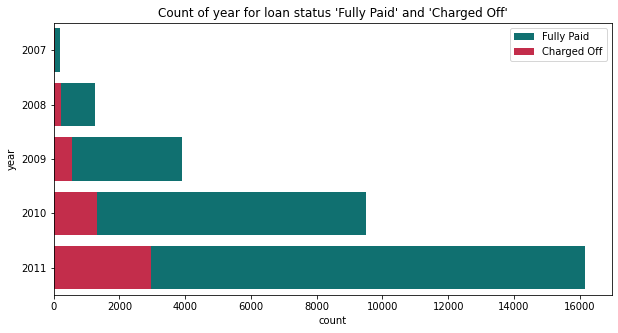

In [ ]:
uni_variate_plot(loan_analysis,'year')

In [ ]:
#analyzing the number of applicants month-wise
analyse_col(loan_analysis,'month')

Various values present in the attribue month:


month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
loan_status,,,,,,,,,,,,
Charged Off,0.96%,1.22%,1.71%,0.68%,0.79%,1.22%,1.21%,0.89%,1.18%,1.48%,1.46%,1.4%
Fully Paid,6.45%,7.71%,9.09%,5.37%,5.33%,7.51%,7.07%,6.09%,6.43%,8.81%,8.2%,7.73%


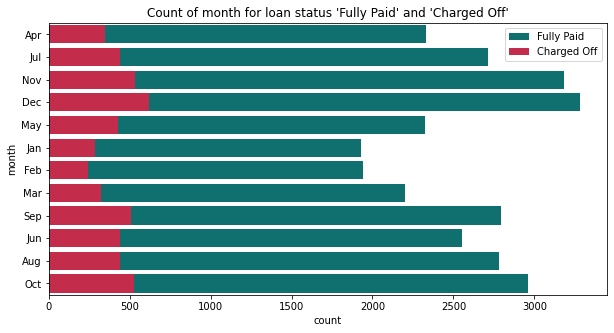

In [ ]:
uni_variate_plot(loan_analysis,'month')

In [ ]:
#analyzing the purpose of loan applicants
analyse_col(loan_analysis,'purpose')

Various values present in the attribue purpose:


purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
loan_status,,,,,,,,,,,,,,
Charged Off,0.42%,1.35%,7.17%,0.14%,0.86%,0.15%,0.55%,0.27%,0.23%,1.58%,0.04%,1.05%,0.14%,0.25%
Fully Paid,3.49%,11.71%,40.51%,0.69%,6.52%,0.78%,4.99%,1.48%,1.25%,8.32%,0.2%,2.85%,0.8%,2.21%


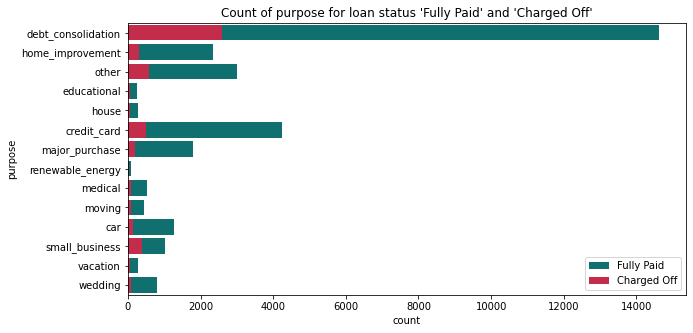

In [ ]:
uni_variate_plot(loan_analysis,'purpose')

In [ ]:
#analyzing the intrest rates
analyse_col(loan_analysis,'int_rate_range')

Various values present in the attribue int_rate_range:


int_rate_range,0-5,5-10,10-15,15-20,20-25
loan_status,,,,,
Charged Off,0.0%,1.98%,6.85%,4.6%,0.76%
Fully Paid,0.0%,29.48%,40.74%,14.32%,1.27%


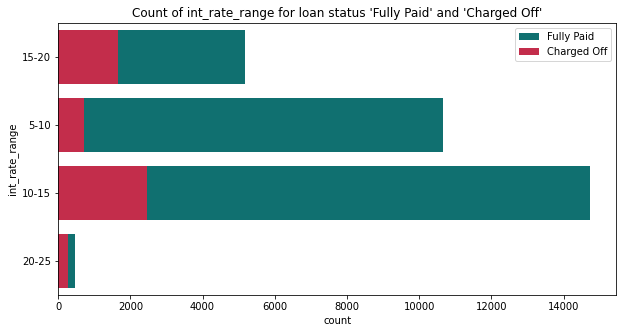

In [ ]:
uni_variate_plot(loan_analysis,'int_rate_range')

In [ ]:
#analyzing the most prefered term
analyse_col(loan_analysis,'term')

Various values present in the attribue term:


term,36 months,60 months
loan_status,,
Charged Off,8.03%,6.18%
Fully Paid,67.04%,18.76%


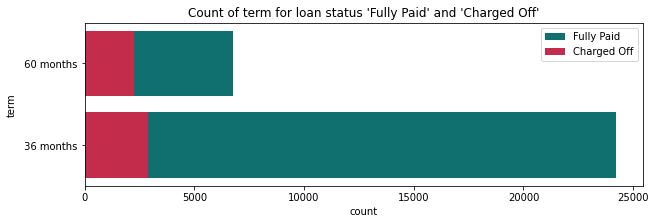

In [ ]:
uni_variate_plot(loan_analysis,'term',10,3)

In [ ]:
#analyzing the employee years
analyse_col(loan_analysis,'bin_emp_years')

Various values present in the attribue bin_emp_years:


bin_emp_years,<1year,1-3years,4-6years,7-9years,10+years
loan_status,,,,,
Charged Off,1.56%,4.19%,3.26%,1.67%,3.52%
Fully Paid,9.87%,26.65%,20.14%,10.09%,19.05%


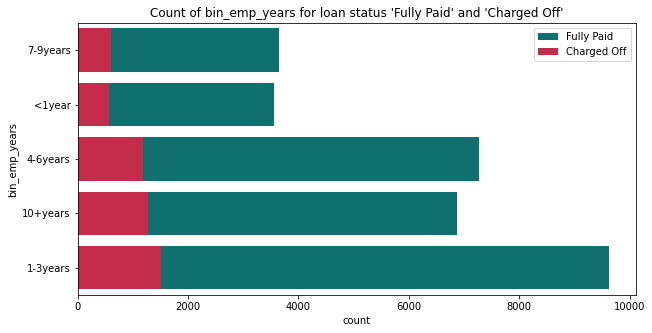

In [ ]:
uni_variate_plot(loan_analysis,'bin_emp_years')

In [ ]:
#analyzing the grade
analyse_col(loan_analysis,'grade')

Various values present in the attribue grade:


grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,1.45%,3.58%,3.39%,2.84%,1.85%,0.81%,0.27%
Fully Paid,24.19%,26.68%,17.05%,10.45%,5.16%,1.74%,0.53%


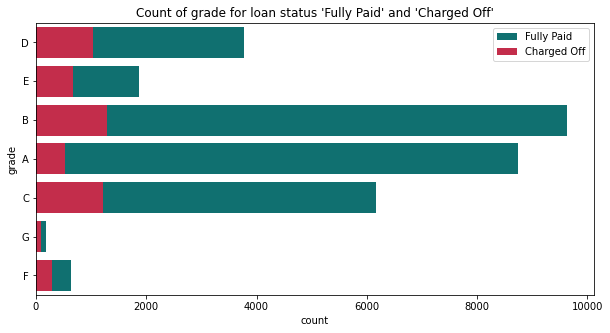

In [ ]:
uni_variate_plot(loan_analysis,'grade')

**Key Takeaways:**

Observations from the pre-processed data:
*   Around 53% of the applicants availble in the dataset have applied for a loan during the year 2011 and the month December has the most most loan funding.
*   The top purpose of applying for a loan among the applicants seems to be 'debt consolidation'
*   Most loan applicants seem to opt for interest rate between 10% and 15%
*   75% of the applicants opt for a term of 36 months
*   Major number of loan applicants have a work experience between 1 and 3 years
*   Large numnber of applicants fall under Grade B


---




In [ ]:
#defining a function to find the probabilty of factors leading to loan default
def variate_graph(df, col: str, loan_status: list = ['Charged Off',"Fully Paid"], show_df: bool = True):
  df = pd.crosstab(df[col], df['loan_status'], margins=True).reset_index()[:-1]
  df['CO_prob'] = df['Charged Off']/df['All']
  df['FP_prob'] = df['Fully Paid']/df['All']
  df = df.sort_values(by=['CO_prob','FP_prob'],ascending=False)
  if loan_status:
    if show_df:
      display(df.head(3))

    ylabel = col.replace("_", " ").title()
    height = max(1, df.shape[0]/2.5)
    fig, ax = plt.subplots(1,2, figsize=(25, height))
    for index, axis in enumerate(ax):
      prob_col = '{} probability'.format(loan_status[index])
      df[prob_col] = round(df[loan_status[index]]/ df['All'], 2)
      f = sns.barplot(data=df, y=col, x=prob_col, palette='deep', ax=axis)
      f.set(ylabel =ylabel, title= "{} vs {}".format(ylabel, loan_status[index]))
  else:
    print("Invalid loan Status:", loan_status)

loan_status,purpose,Charged Off,Fully Paid,All,CO_prob,FP_prob
11,small_business,378,1028,1406,0.268848,0.731152
10,renewable_energy,16,72,88,0.181818,0.818182
3,educational,50,249,299,0.167224,0.832776


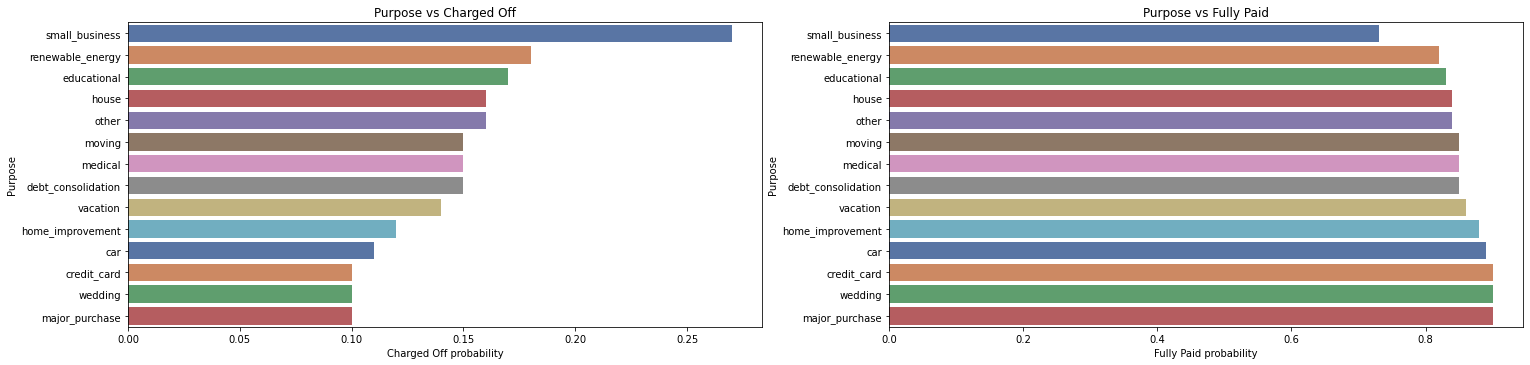

In [ ]:
variate_graph(loan_analysis, 'purpose')

loan_status,term,Charged Off,Fully Paid,All,CO_prob,FP_prob
1,60 months,2231,6775,9006,0.247724,0.752276
0,36 months,2899,24217,27116,0.106911,0.893089


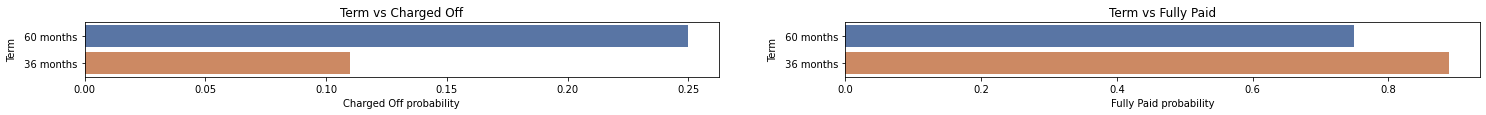

In [ ]:
variate_graph(loan_analysis, 'term')

loan_status,home_ownership,Charged Off,Fully Paid,All,CO_prob,FP_prob
2,OTHER,18,78,96,0.187500,0.812500
4,RENT,2630,14873,17503,0.150260,0.849740
3,OWN,364,2209,2573,0.141469,0.858531


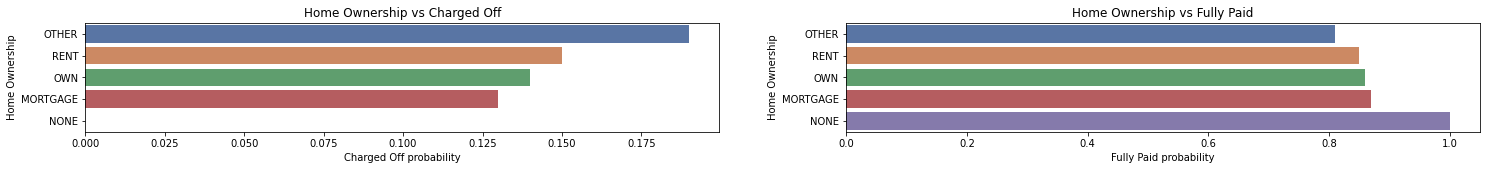

In [ ]:
variate_graph(loan_analysis, 'home_ownership')

loan_status,addr_state,Charged Off,Fully Paid,All,CO_prob,FP_prob
28,NE,3,2,5,0.600000,0.400000
32,NV,97,349,446,0.217489,0.782511
0,AK,15,59,74,0.202703,0.797297


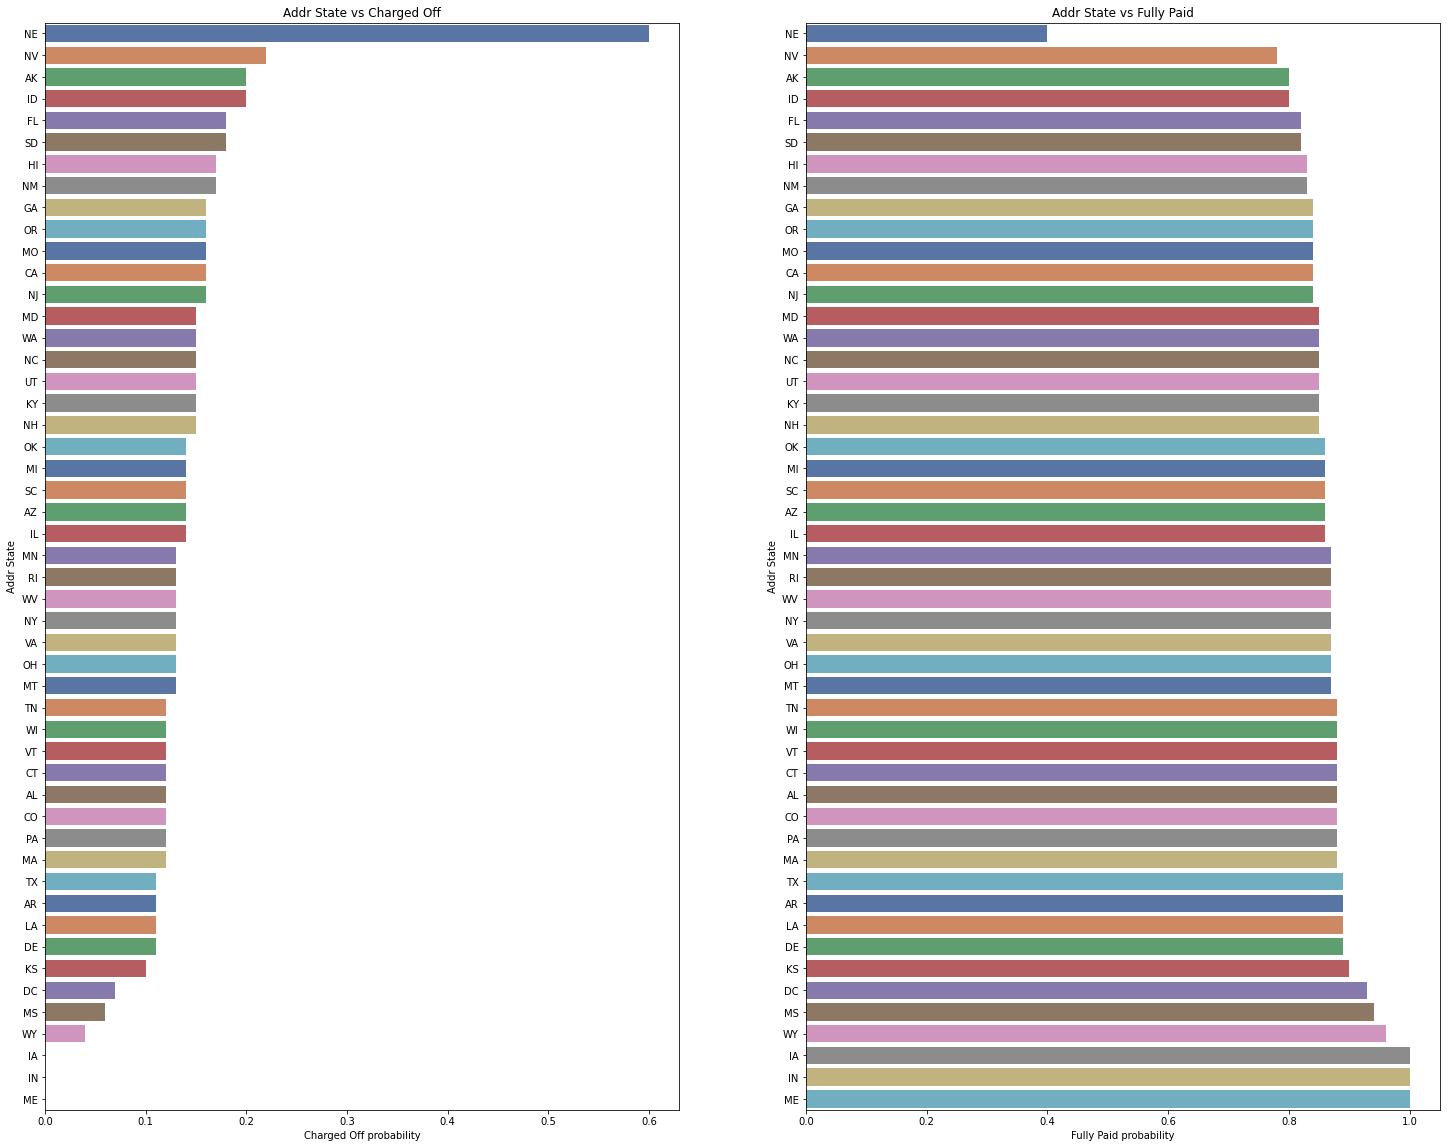

In [ ]:
variate_graph(loan_analysis, 'addr_state')

loan_status,annual_income_range,Charged Off,Fully Paid,All,CO_prob,FP_prob
3,600000-800000,5,18,23,0.217391,0.782609
0,0-200000,5079,30548,35627,0.142560,0.857440
4,800000-1000000,1,7,8,0.125000,0.875000


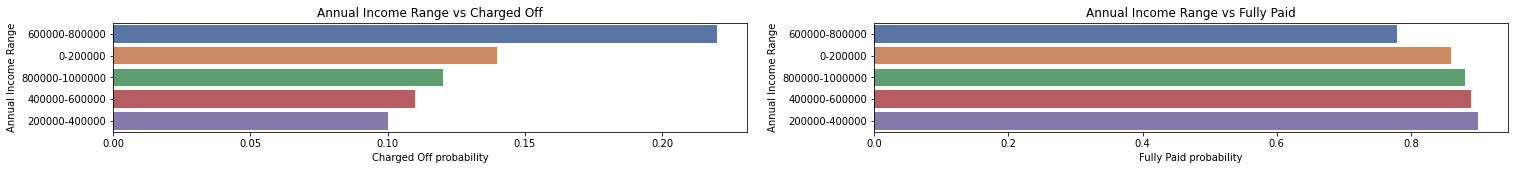

In [ ]:
variate_graph(loan_analysis, 'annual_income_range')

loan_status,emp_length,Charged Off,Fully Paid,All,CO_prob,FP_prob
1,10+ years,1270,6881,8151,0.155809,0.844191
7,7 years,254,1408,1662,0.152828,0.847172
8,8 years,198,1192,1390,0.142446,0.857554


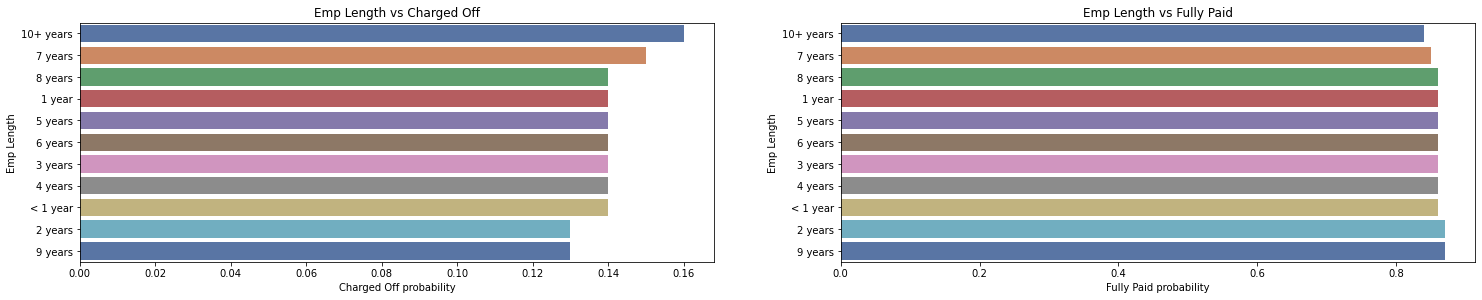

In [ ]:
variate_graph(loan_analysis, 'emp_length')

loan_status,grade,Charged Off,Fully Paid,All,CO_prob,FP_prob
6,G,97,191,288,0.336806,0.663194
5,F,294,628,922,0.318872,0.681128
4,E,670,1863,2533,0.264508,0.735492


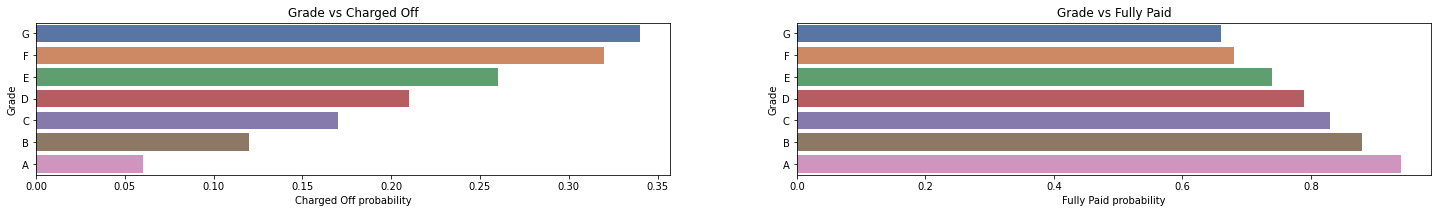

In [ ]:
variate_graph(loan_analysis, 'grade')

loan_status,sub_grade,Charged Off,Fully Paid,All,CO_prob,FP_prob
29,F5,47,54,101,0.465347,0.534653
32,G3,18,23,41,0.439024,0.560976
31,G2,28,47,75,0.373333,0.626667


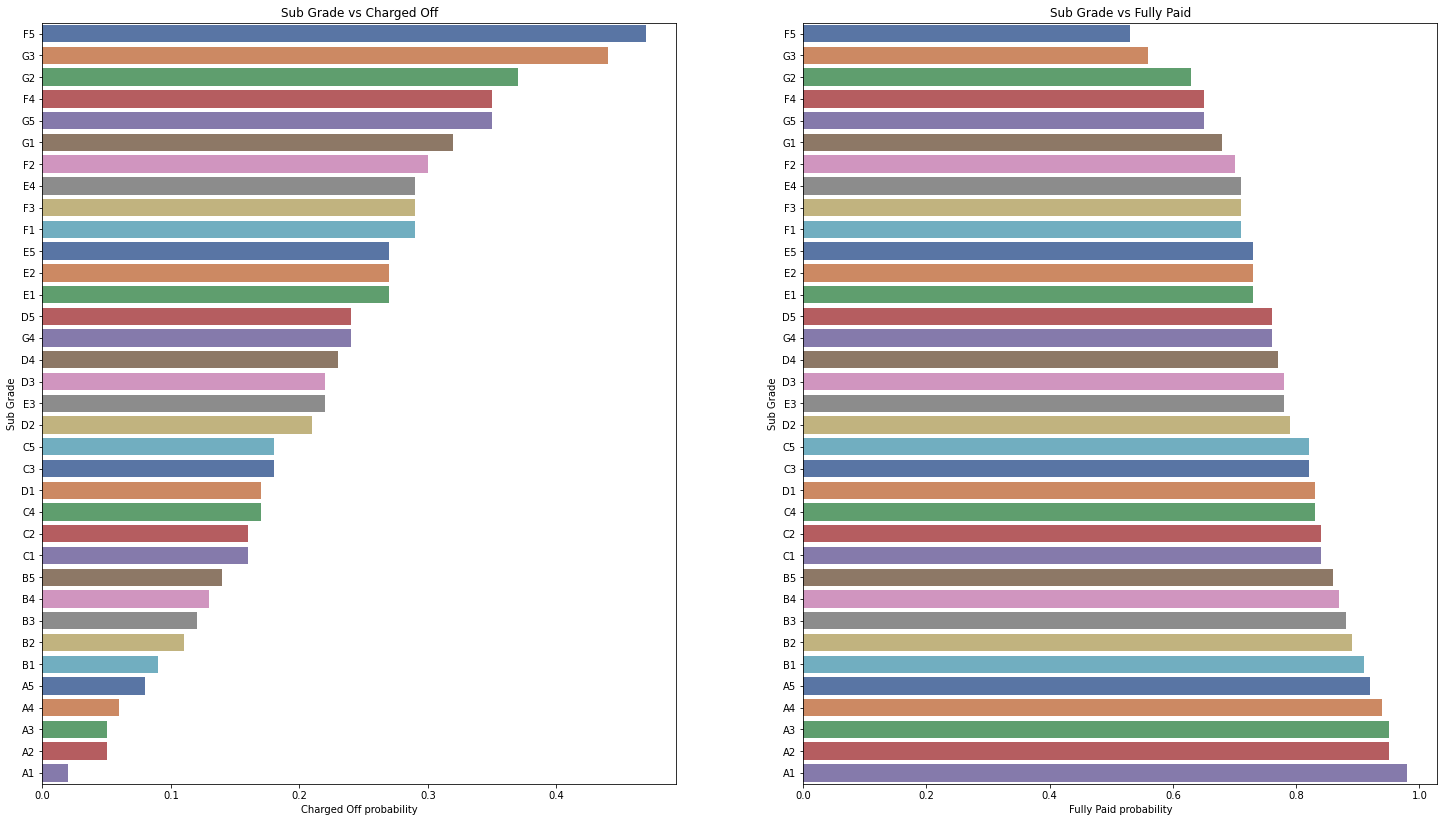

In [ ]:
variate_graph(loan_analysis, 'sub_grade')

loan_status,int_rate_range,Charged Off,Fully Paid,All,CO_prob,FP_prob
3,20-25,275,457,732,0.375683,0.624317
2,15-20,1663,5172,6835,0.243307,0.756693
1,10-15,2475,14716,17191,0.143971,0.856029


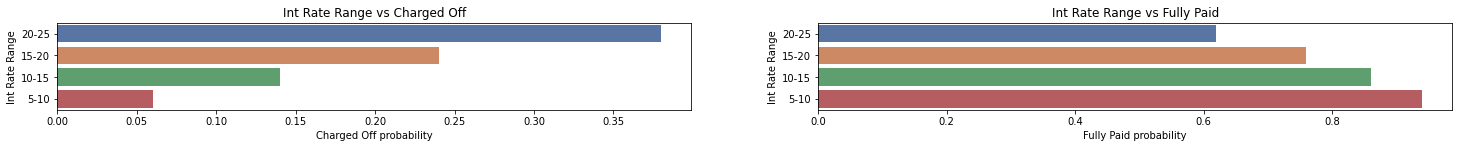

In [ ]:
variate_graph(loan_analysis, 'int_rate_range')

loan_status,loan_amount_range,Charged Off,Fully Paid,All,CO_prob,FP_prob
4,28000-35000,238,816,1054,0.225806,0.774194
3,21000-28000,497,2117,2614,0.190130,0.809870
2,14000-21000,1089,5595,6684,0.162926,0.837074


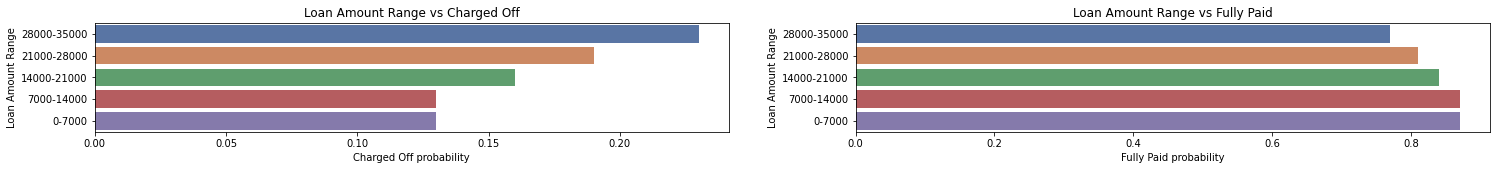

In [ ]:
variate_graph(loan_analysis, 'loan_amount_range')

loan_status,verification_status,Charged Off,Fully Paid,All,CO_prob,FP_prob
2,Verified,1873,9516,11389,0.164457,0.835543
1,Source Verified,1338,7849,9187,0.145641,0.854359
0,Not Verified,1919,13627,15546,0.123440,0.876560


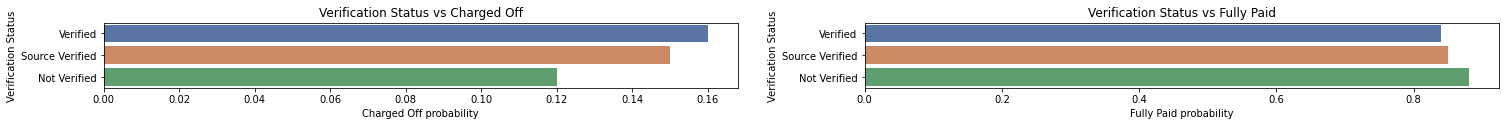

In [ ]:
variate_graph(loan_analysis, 'verification_status')

**Key Takeaways:** 

Loan Default probablity is high when,


*   The purpose of the loan is 'small business'
*   Interest rage is high
*   Grade is beyond D




---



Analysis of DTI (Debt to Income ratio) on loan status and loan amount

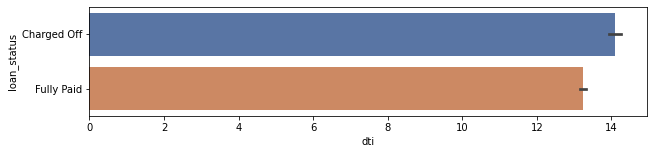

In [ ]:
plt.figure(figsize=(10,2))
sns.barplot(y='loan_status',x='dti',data=loan_analysis,palette='deep')
plt.show()

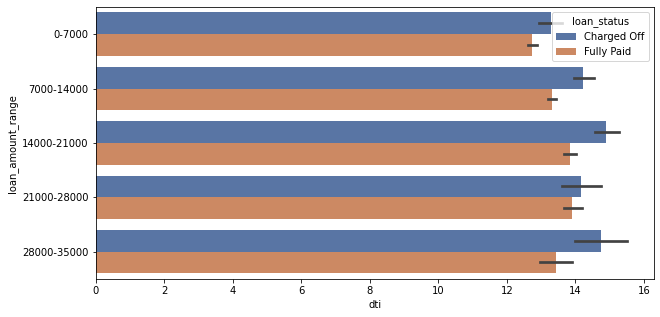

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(y='loan_amount_range',x='dti',data=loan_analysis,hue='loan_status',palette='deep')
plt.show()

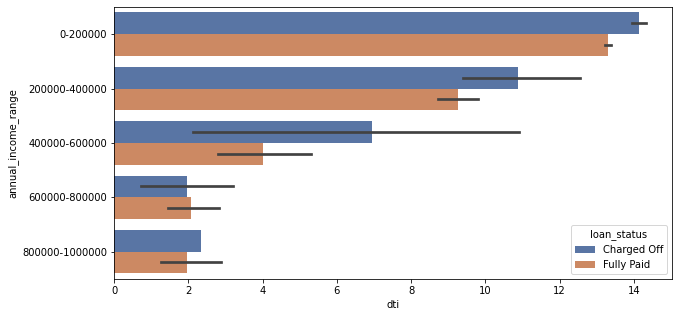

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(y='annual_income_range',x='dti',data=loan_analysis,hue='loan_status',palette='deep')
plt.show()

**Key Takeaways:**


*   Applicants with high value of DTI are likely to default.
*   Annual Income is inversely proprtional to DTI, higher the anuual income lower the DTI value



---



In [ ]:
#defining a function involving 2 columns to measure the probabilty of loan default w.r.t to given attributes
def bi_var_plot(col1,col2):
  df = pd.crosstab([loan_analysis[col1],loan[col2]], loan_analysis['loan_status'], margins=True).reset_index()[:-1]
  df['co_prob'] = df['Charged Off']/df['All']
  df1 =df.loc[df.groupby(col1)['co_prob'].idxmax()]
  df1 = df1.sort_values(by='co_prob',ascending=False)
  display(df1[[col1,col2,'co_prob']][:3])

  height = max(1, df.shape[1]/2.5)
  plt.figure(figsize=(20,height))
  sns.barplot(x=col1,y='co_prob',hue=col2,data=df)
  plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.)
  plt.show()


loan_status,purpose,bin_emp_years,co_prob
59,small_business,10+years,0.300000
63,vacation,7-9years,0.250000
52,renewable_energy,4-6years,0.222222


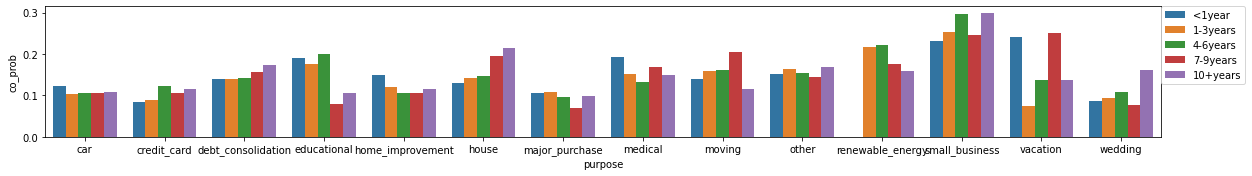

In [ ]:
bi_var_plot('purpose','bin_emp_years')

loan_status,purpose,int_rate_range,co_prob
43,renewable_energy,20-25,1.000000
31,medical,20-25,0.625000
47,small_business,20-25,0.571429


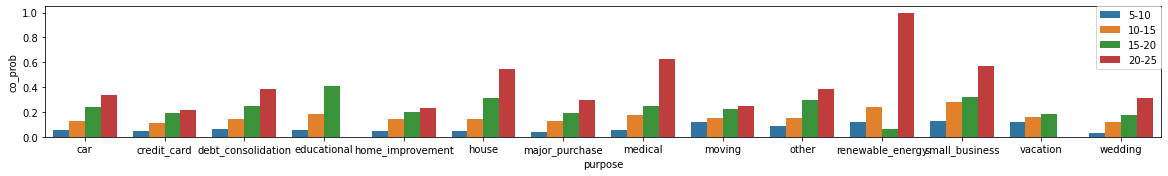

In [ ]:
bi_var_plot('purpose','int_rate_range')

loan_status,purpose,verification_status,co_prob
35,small_business,Verified,0.308664
32,renewable_energy,Verified,0.250000
25,moving,Source Verified,0.211640


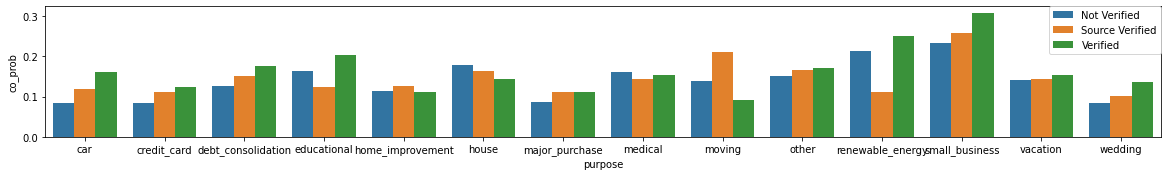

In [ ]:
bi_var_plot('purpose','verification_status')

loan_status,purpose,term,co_prob
7,educational,60 months,0.428571
23,small_business,60 months,0.385343
11,house,60 months,0.297030


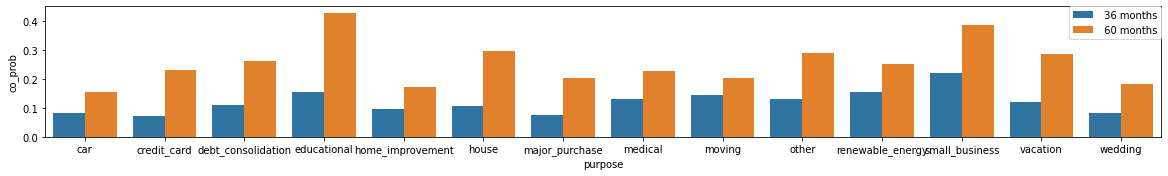

In [ ]:
bi_var_plot('purpose','term')

loan_status,purpose,year,co_prob
39,moving,2007,0.500000
53,small_business,2007,0.333333
63,wedding,2007,0.285714


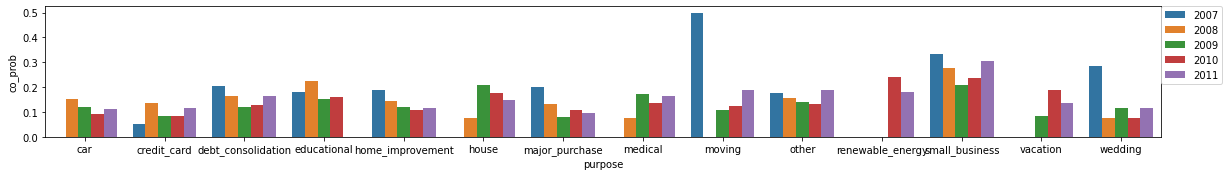

In [ ]:
bi_var_plot('purpose','year')

loan_status,term,bin_emp_years,co_prob
9,60 months,10+years,0.260008
0,36 months,<1year,0.108336


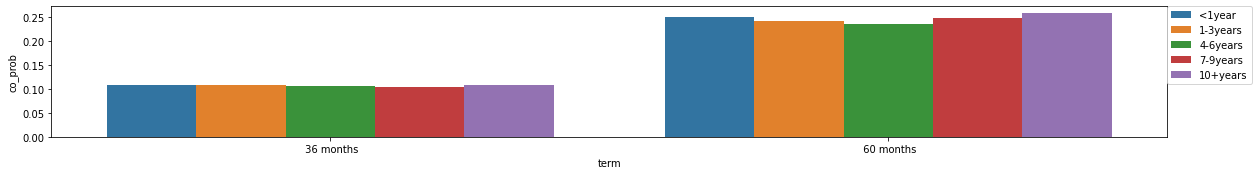

In [ ]:
bi_var_plot('term','bin_emp_years')

loan_status,int_rate_range,term,co_prob
7,20-25,60 months,0.376877
5,15-20,60 months,0.289600
3,10-15,60 months,0.209873


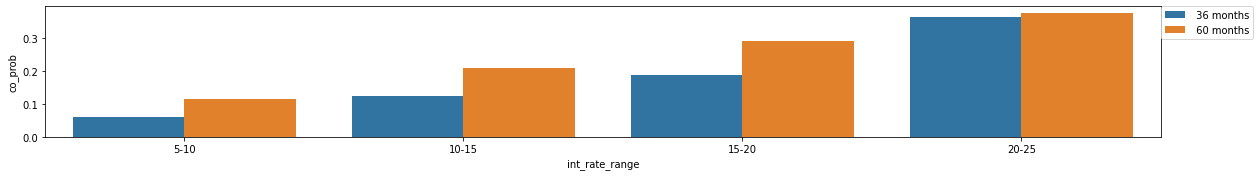

In [ ]:
bi_var_plot('int_rate_range','term')

loan_status,loan_amount_range,int_rate_range,co_prob
11,14000-21000,20-25,0.429293
7,7000-14000,20-25,0.413793
19,28000-35000,20-25,0.354286


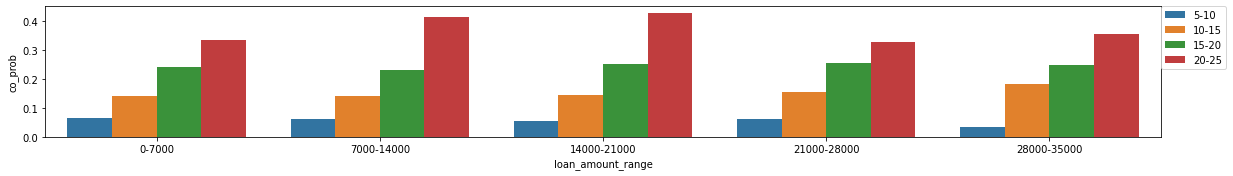

In [ ]:
bi_var_plot('loan_amount_range','int_rate_range')

loan_status,grade,int_rate_range,co_prob
12,E,20-25,0.397436
14,F,20-25,0.396419
16,G,20-25,0.338403


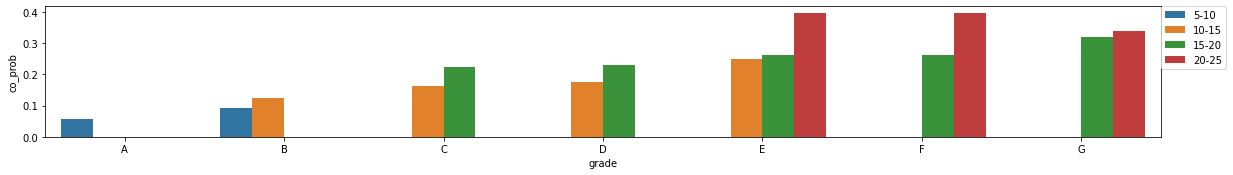

In [ ]:
bi_var_plot('grade','int_rate_range')

##Analysis of Continous variables (Bi-variate)

In [ ]:
round(loan_default.describe(),2)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,emp_years,year
count,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.0,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00,5130.00
mean,12236.15,11881.85,10957.18,13.89,339.19,62677.71,14.09,0.17,1.06,9.27,0.08,13572.2,21.58,6932.62,6443.98,4018.55,328.15,5.13,2010.35
std,8056.53,7736.25,7645.27,3.63,215.87,44684.65,6.54,0.54,1.14,4.52,0.28,14825.3,11.46,6648.68,6530.06,3994.38,519.49,3.58,0.90
min,900.00,900.00,0.00,5.42,22.79,4080.00,0.00,0.00,0.00,2.00,0.00,0.0,2.00,0.00,0.00,0.00,0.00,0.00,2007.00
25%,6000.00,5906.25,5000.00,11.46,171.54,38214.75,9.24,0.00,0.00,6.00,0.00,4078.0,13.00,2242.02,1890.64,1234.27,114.01,2.00,2010.00
50%,10000.00,10000.00,9600.00,13.64,298.33,54000.00,14.38,0.00,1.00,9.00,0.00,9432.5,20.00,4944.04,4428.99,2770.60,241.75,5.00,2011.00
75%,17000.00,16000.00,15000.00,16.45,461.49,75000.00,19.29,0.00,2.00,12.00,0.00,17700.0,29.00,9363.04,8651.05,5399.71,411.57,9.00,2011.00
max,35000.00,35000.00,35000.00,24.40,1305.19,840000.00,29.85,8.00,8.00,38.00,2.00,148829.0,70.00,51745.45,51671.58,31115.81,12818.38,10.00,2011.00


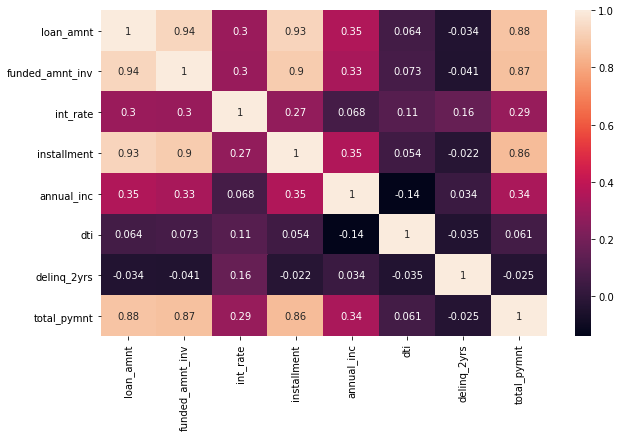

In [ ]:
#finding the correlation and plotting them in a heatmap
cols = ['loan_amnt','funded_amnt_inv','int_rate','installment','annual_inc','dti','delinq_2yrs','total_pymnt']
corr = loan_analysis[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)
plt.show()

**Key Takeaways:**

*   The amount funded by investors though might not match the Loan Amount, increases with the loan amount
*   An applicant who is frequently delinquent in the last 2 years is less likely to pay the total payment or the loan amount
*   Decrease in the annual income tends for a higher DTI value which can be 
considered as a factor on loan default






---
Aanlysis on Loan Amount


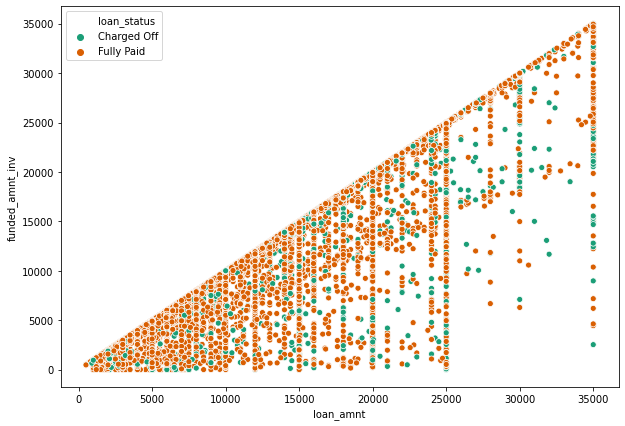

In [ ]:
#loan amount vs amount funded by investors
plt.figure(figsize=(10,7))
sns.scatterplot(x='loan_amnt',y='funded_amnt_inv',data=loan_analysis,hue='loan_status',palette='Dark2')
plt.show()

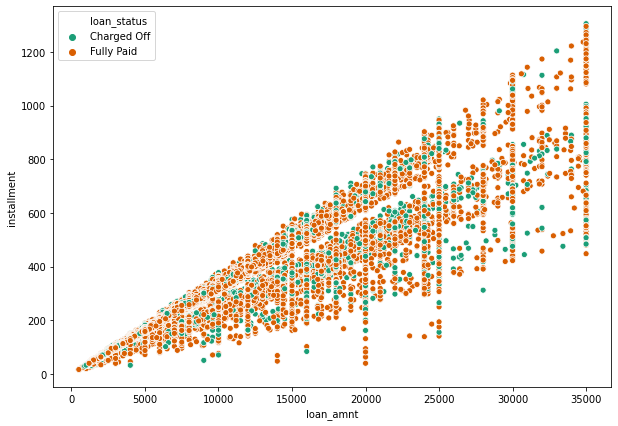

In [ ]:
#loan amount vs the monthly payment owed by the borrower
plt.figure(figsize=(10,7))
sns.scatterplot(x='loan_amnt',y='installment',data=loan_analysis,hue='loan_status',palette='Dark2')
plt.show()

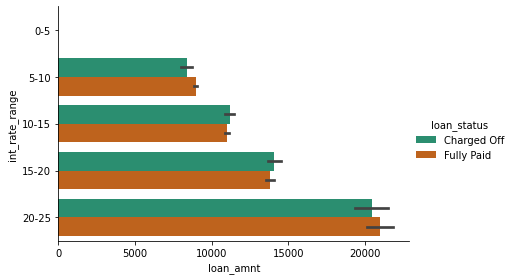

In [ ]:
sns.catplot(y='int_rate_range',x='loan_amnt',data=loan_analysis,hue='loan_status',kind='bar',height=4, aspect=1.5,palette='Dark2')
plt.show()

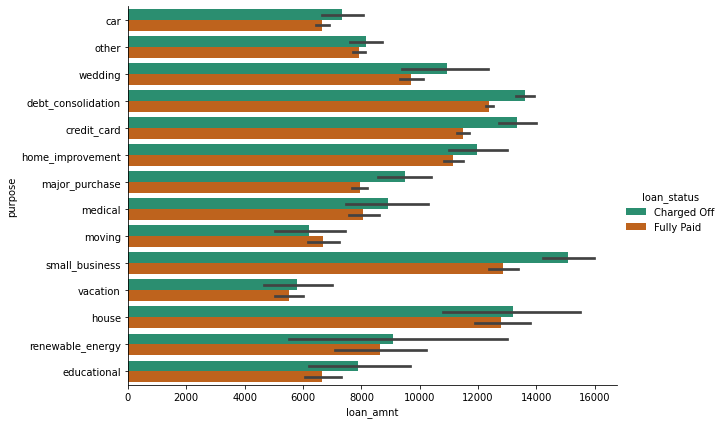

In [ ]:
sns.catplot(y='purpose',x='loan_amnt',data=loan_analysis,hue='loan_status',kind='bar',height=6, aspect=1.5,palette='Dark2')
plt.show()

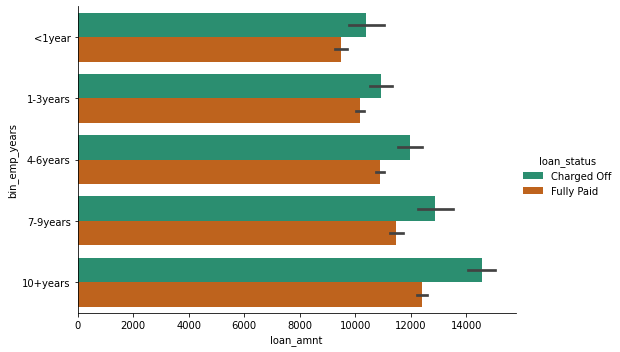

In [ ]:
sns.catplot(y='bin_emp_years',x='loan_amnt',data=loan_analysis,hue='loan_status',kind='bar',height=5, aspect=1.5,palette='Dark2')
plt.show()

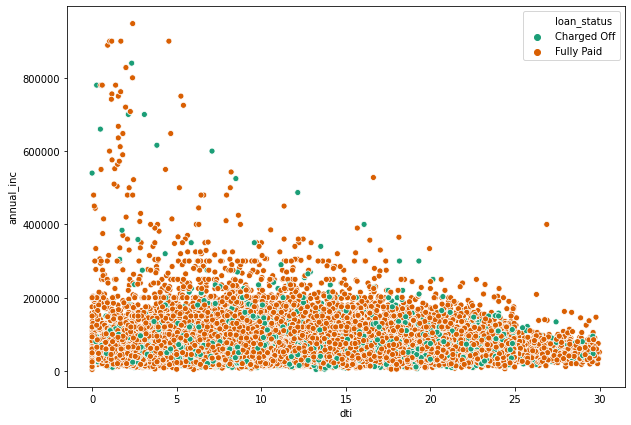

In [ ]:
#annual income vs dti
plt.figure(figsize=(10,7))
sns.scatterplot(y='annual_inc',x='dti',data=loan_analysis,hue='loan_status',palette='Dark2')
plt.show()

<Figure size 720x504 with 0 Axes>

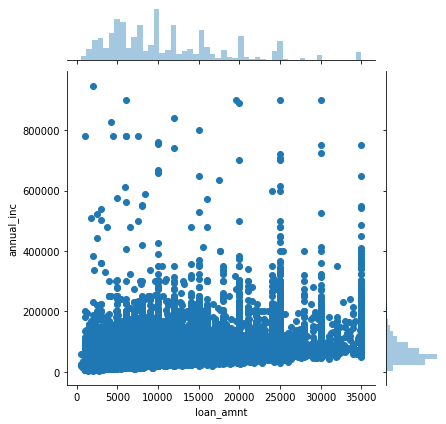

In [ ]:
#loan amount vs annual income
plt.figure(figsize=(10,7))
sns.jointplot(x="loan_amnt", y="annual_inc", data=loan_analysis);
plt.show()

**Key Takeaways:**

*   The amount funded by investors increases with the loan amount but most often less to the amount requested by the borrower.
*   Large loan amounts are applied for small business and this purpsose is also the cause of high default rate
*   Applicants with 10+ years of employment are likely to apply for a large loan amount and are likely to default



---







In Conslusion, 

The factors influencing Loan Status can be summarized as below:

Purpose: The probability of a loan default is high when it is obtained for **small business**.

Term: The probability of a loan default is high for a tenure of **60 months**.

Grade: The probability of a loan default is high when the **grade rank is low** (beyond Grade D).

Interest Rate: The probability of a loan default is high when the interest rate is **beyond 15%**

Employment years: The probability of a loan default is high when the applicant has employment years for **10+ years**


Area: Loan Applicants from the state **‘NE’**(Nebraska) are more likely to default.
